In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import re
import statsmodels.stats.multitest as multi
plt.rcParams['pdf.use14corefonts'] = True

In [2]:
guardant_table = pd.read_excel('../data/Leshchiner_et_al_Tables.xlsx', sheet_name='SuppTable2_GuardantDatabase')
guardant_drug_table = pd.read_csv('../data/treatment_information_for_classifier.tsv', sep='\t', index_col=0)

In [3]:
# Get list of genes in panel
gene_list = list(pd.unique(guardant_table['gene']))

In [4]:
# List of drugs
drug_index = ['kadcyla', 'tdm-1', 'tykerb', 'nerlynx', 'palbociclib', 'ibrance', 'fulvestrant', 'faslodex', 'ribociclib', 'kisqali', 'tamoxifen',
              'abemiciclib', 'verzenio', 'letrozole', 'femara', 'exemestane', 'aromasin', 'anastrozole', 'arimidex', 'anti-her2']

In [5]:
# Create full event matrix of guardant genomic data

guardant_mut_table = guardant_table.loc[(guardant_table['mut_type'] != 'synonymous') & (guardant_table['mut_type'] != 'amp')
  ].groupby(['patient_id', 'gene']).size().unstack().fillna(0).astype(bool).astype(int)
guardant_amp_table = guardant_table.loc[(guardant_table['mut_type'] == 'amp')
  ].groupby(['patient_id', 'gene']).size().unstack().fillna(0).astype(bool).astype(int)
for gene in gene_list:
    if gene not in guardant_mut_table.columns:
        guardant_mut_table[gene] = 0
    if gene not in guardant_amp_table.columns:
        guardant_amp_table[gene] = 0
guardant_mut_table = guardant_mut_table[gene_list]
guardant_amp_table = guardant_amp_table[gene_list]
guardant_amp_table.columns += '_amp'

full_mat = pd.concat([guardant_mut_table, guardant_amp_table, guardant_drug_table], axis=1).fillna(0)

In [6]:
classifier_results = pd.read_excel('../data/GuardantClassifierAnnotations_12172023.xlsx', sheet_name='Sheet1', index_col=0)

In [7]:
er_patients = classifier_results.loc[classifier_results['ER_final'] == 'ER+'].index
her2_patients = classifier_results.loc[classifier_results['HER2_final'] == 'HER2+'].index
tn_patients = classifier_results.loc[classifier_results['TN_final'] == 'TN'].index

In [8]:
# Create matrix for comut

mut_types = ['synonymous', 'VUS', 'missense', 'indel', 'nonsense', 'splice', 'fusion']

comut_mat = pd.DataFrame(columns=er_patients, index=pd.unique(guardant_table['gene'])).fillna(0)
for p in er_patients:
    p_df = guardant_table.loc[guardant_table['patient_id'] == p]
    for i, mut_type in enumerate(mut_types):
        type_df = p_df.loc[p_df['mut_type'] == mut_type]
        comut_mat.loc[type_df['gene'], p] = i + 1

In [9]:
# Load metabric data
metabric_clin = pd.read_csv('../data/metabric_data/data_clinical_patient.txt', sep='\t', skiprows=4).set_index('PATIENT_ID')
metabric_maf = pd.read_csv('../data/metabric_data/data_mutations_extended.tsv', sep='\t')
metabric_maf['patient'] = metabric_maf['Tumor_Sample_Barcode'].apply(lambda s: s.split('-')[1])
metabric_seg = pd.read_csv('../data/metabric_data/data_CNA.txt', sep='\t').set_index('Hugo_Symbol').T.iloc[1:]
for g in gene_list:
    if g not in metabric_seg.columns:
        metabric_seg[g] = 0.
metabric_seg = metabric_seg[gene_list]
metabric_seg['patient'] = metabric_seg.index.map(lambda s: s.split('-')[1])

In [10]:
metabric_clin['DX_ER'] = metabric_clin['DX_ER'].str.strip()
metabric_clin['DX_HER2OVERALL'] = metabric_clin['DX_HER2OVERALL'].str.strip()

In [11]:
# Blacklist non-coding mutations
blacklisted_classifications = ['Silent', 'Intron', "3'UTR", "3'Flank", "5'Flank", "5'UTR", 'RNA']

In [12]:
# Get Metabric events
mut_types = ['synonymous', 'missense', 'indel', 'nonsense', 'splice', 'fusion']
mut_type_dict = {'Missense_Mutation': 'missense', 'Splice_Site': 'splice', 'Silent': 'synonymous', 'Intron': 'synonymous',
                 'Nonsense_Mutation': 'nonsense', 'Frame_Shift_Del': 'indel', 'Frame_Shift_Ins': 'indel', 'In_Frame_Del': 'indel',
                 'In_Frame_Ins': 'indel'}

metabric_er_patients = metabric_clin.loc[metabric_clin['DX_ER'] == 'POSITIVE'].index

metabric_comut_mat = pd.DataFrame(columns=metabric_er_patients,
                                  index=pd.unique(metabric_maf.loc[metabric_maf['Hugo_Symbol'].isin(gene_list), 'Hugo_Symbol'])).fillna(0)
for p in metabric_er_patients:
    p_df = metabric_maf.loc[metabric_maf['patient'] == p]
    for i, mut_type in enumerate(mut_types):
        gene_df = p_df.loc[p_df['Hugo_Symbol'].isin(gene_list)]
        type_df = gene_df.loc[gene_df['Variant_Classification'].apply(lambda t: mut_type_dict[t]) == mut_type]
        metabric_comut_mat.loc[type_df['Hugo_Symbol'], p] = i + 1

In [13]:
# Get prevalences and errors
full_er_pos_freq = (comut_mat > 1).sum(axis='columns')
full_er_pos_prev = full_er_pos_freq / len(comut_mat.columns)
full_er_pos_prev_low, full_er_pos_prev_high = scipy.stats.beta.interval(.9, full_er_pos_freq + 1, len(comut_mat.columns) - full_er_pos_freq + 1)
full_er_pos_prev_error = np.abs(np.array((full_er_pos_prev_high, full_er_pos_prev_low)) - full_er_pos_prev.values)

metabric_er_pos_freq = (metabric_comut_mat > 1).sum(axis='columns')
metabric_er_pos_freq = metabric_er_pos_freq[metabric_er_pos_freq > 0]
for gene in ['EZH2', 'ALK', 'PDGFRA']:
    if gene not in metabric_er_pos_freq.index:
        metabric_er_pos_freq[gene] = 0
metabric_er_pos_prev = metabric_er_pos_freq / len(metabric_comut_mat.columns)
metabric_er_pos_prev_low, metabric_er_pos_prev_high = scipy.stats.beta.interval(.9, metabric_er_pos_freq + 1, len(metabric_comut_mat.columns) - metabric_er_pos_freq + 1)
metabric_er_pos_prev_error = np.abs(np.array((metabric_er_pos_prev_high, metabric_er_pos_prev_low)) - metabric_er_pos_prev.values)

In [14]:
# Calculate q-values
p_values = {}
for gene in set(full_er_pos_prev.index) & set(metabric_er_pos_prev.index):
    cont_table = np.array([[full_er_pos_freq[gene], len(comut_mat.columns) - full_er_pos_freq[gene]],
                           [metabric_er_pos_freq[gene], len(metabric_comut_mat.columns) - metabric_er_pos_freq[gene]]])
    p_values[gene] = scipy.stats.fisher_exact(cont_table)[1]
p_values = pd.Series(p_values)
p_arr = np.array(sorted(p_values.values))
eve_order = sorted(p_values.index, key=p_values.__getitem__)
rank_arr = np.arange(1, len(p_arr) + 1)
q_arr = multi.fdrcorrection(p_arr, is_sorted=True, alpha=.1)[1]
q_values = pd.Series(dict(zip(eve_order, q_arr)))

In [15]:
# Set order of events
order = list((np.log10(q_values) * ((full_er_pos_prev[q_values.index] > metabric_er_pos_prev[q_values.index]).astype(int) * 2 - 1)).sort_values(ascending=False).index)
full_err_index = [list(full_er_pos_prev.index).index(x) for x in order]
metabric_err_index = [list(metabric_er_pos_prev.index).index(x) for x in order]

/var/folders/ty/nj77bh0j35b1mmnbxssy9xz40000gn/T/ipykernel_38499/1188222923.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(np.abs(np.round(axes[0].get_xticks(), 1)))


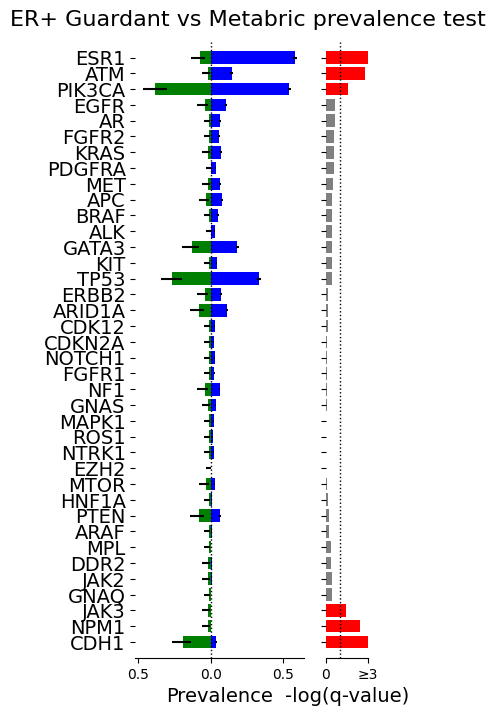

In [16]:
# Plot comparison plot
x = np.arange(len(order))
fig, axes = plt.subplots(figsize=(3, 8), ncols=2, nrows=1, sharey=True, gridspec_kw={'width_ratios': (4, 1)})

axes[0].barh(x, full_er_pos_prev[order], color='blue', label='Guardant', xerr=full_er_pos_prev_error[:, full_err_index])
axes[0].barh(x, -metabric_er_pos_prev[order], color='green', label='Metabric', xerr=metabric_er_pos_prev_error[:, metabric_err_index])
axes[0].axvline(0, linestyle='dotted', lw=1, c='k')
axes[0].set_ylim(min(x) - 1, max(x) + 1)
axes[0].set_xlabel('Prevalence', fontsize=14)
axes[0].set_xticklabels(np.abs(np.round(axes[0].get_xticks(), 1)))
# axes[0].legend(loc='lower right')
axes[0].set_yticks(x)
axes[0].set_yticklabels(order, fontsize=14)

sig_y = [order.index(x) for x in order if q_values[x] <= .1]
no_sig_y = [order.index(x) for x in order if q_values[x] > .1]
axes[1].barh(sig_y, -np.log10(q_values[order][q_values[order] <= .1]), color='red')
axes[1].barh(no_sig_y, -np.log10(q_values[order][q_values[order] > .1]), color='gray')
axes[1].axvline(-np.log10(.1), linestyle='dotted', lw=1, c='k')
axes[1].set_xlim(0, 3)
axes[1].set_xticks([0, 3])
axes[1].set_xticklabels(['0','≥3'])
axes[1].set_xlabel('-log(q-value)', fontsize=14)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.suptitle('ER+ Guardant vs Metabric prevalence test', fontsize=16, y=.92)
# plt.savefig('er+_guardant_vs_metabric_prev_test.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [17]:
tcga_table = pd.read_csv('../data/tcga_table.tsv', sep='\t')

In [18]:
# Load TCGA clinical annotations
tcga_clin_data = pd.read_csv('../data/brca_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t')

In [19]:
# Set non-coding variant classifications
non_coding_cats = ['lincRNA', "5'Flank", 'IGR', 'RNA', "3'UTR", "5'UTR", 'Intron', 'Silent']

In [20]:
# Annotate receptor status based on subtype
tcga_clin_data['er_status'] = tcga_clin_data['Subtype'].isin(['BRCA_LumA', 'BRCA_LumB', 'BRCA_Normal'])
tcga_clin_data['her2_status'] = tcga_clin_data['Subtype'] == 'BRCA_Her2'
tcga_clin_data.loc[pd.isnull(tcga_clin_data['Subtype']), 'er_status'] = np.nan
tcga_clin_data.loc[pd.isnull(tcga_clin_data['Subtype']) | (tcga_clin_data['Subtype'] == 'BRCA_LumB'), 'her2_status'] = np.nan

/var/folders/ty/nj77bh0j35b1mmnbxssy9xz40000gn/T/ipykernel_38499/3947001429.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  tcga_clin_data.loc[pd.isnull(tcga_clin_data['Subtype']), 'er_status'] = np.nan
/var/folders/ty/nj77bh0j35b1mmnbxssy9xz40000gn/T/ipykernel_38499/3947001429.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  tcga_clin_data.loc[pd.isnull(tcga_clin_data['Subtype']) | (tcga_clin_data['Subtype'] == 'BRCA_LumB'), 'her2_status'] = np.nan


In [21]:
# Get prevalencies and errors
full_er_pos_freq = (comut_mat > 1).sum(axis='columns')
full_er_pos_prev = full_er_pos_freq / len(comut_mat.columns)
full_er_pos_prev_low, full_er_pos_prev_high = scipy.stats.beta.interval(.9, full_er_pos_freq + 1, len(comut_mat.columns) - full_er_pos_freq + 1)
full_er_pos_prev_error = np.abs(np.array((full_er_pos_prev_high, full_er_pos_prev_low)) - full_er_pos_prev.values)

tcga_er_pos_freq = tcga_table.loc[tcga_table['barcode'].isin(tcga_clin_data.loc[(tcga_clin_data['er_status'] == 1), 'Patient ID']) & \
                                  (~tcga_table['Variant_Classification'].isin(non_coding_cats)),
                                  ['Hugo_Symbol', 'barcode']].drop_duplicates().groupby('Hugo_Symbol').size()
tcga_er_pos_freq = tcga_er_pos_freq[tcga_er_pos_freq.index.isin(gene_list)]
tcga_er_pos_freq = tcga_er_pos_freq[tcga_er_pos_freq > 0]
for gene in ['EZH2', 'PDGFRA', 'ALK']:
    if gene not in tcga_er_pos_freq.index:
        tcga_er_pos_freq[gene] = 0
n_tcga_er_pos = ((tcga_clin_data['er_status'] == 1)).sum()
tcga_er_pos_prev = tcga_er_pos_freq / n_tcga_er_pos
tcga_er_pos_prev_low, tcga_er_pos_prev_high = scipy.stats.beta.interval(.9, tcga_er_pos_freq + 1, n_tcga_er_pos - tcga_er_pos_freq + 1)
tcga_er_pos_prev_error = np.abs(np.array((tcga_er_pos_prev_high, tcga_er_pos_prev_low)) - tcga_er_pos_prev.values)

In [22]:
# Calculate q-values
p_values = {}
for gene in set(full_er_pos_prev.index) & set(tcga_er_pos_prev.index):
    cont_table = np.array([[full_er_pos_freq[gene], len(comut_mat.columns) - full_er_pos_freq[gene]],
                           [tcga_er_pos_freq[gene], n_tcga_er_pos - tcga_er_pos_freq[gene]]])
    p_values[gene] = scipy.stats.fisher_exact(cont_table)[1]
p_values = pd.Series(p_values)
p_arr = np.array(sorted(p_values.values))
eve_order = sorted(p_values.index, key=p_values.__getitem__)
rank_arr = np.arange(1, len(p_arr) + 1)
q_arr = multi.fdrcorrection(p_arr, is_sorted=True, alpha=.1)[1]
q_values = pd.Series(dict(zip(eve_order, q_arr)))

In [23]:
# Set order of events
order = list((np.log10(q_values) * ((full_er_pos_prev[q_values.index] > tcga_er_pos_prev[q_values.index]).astype(int) * 2 - 1)).sort_values(ascending=False).index)

full_err_index = [list(full_er_pos_prev.index).index(x) for x in order]
tcga_err_index = [list(tcga_er_pos_prev.index).index(x) for x in order]

/var/folders/ty/nj77bh0j35b1mmnbxssy9xz40000gn/T/ipykernel_38499/89383581.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(np.abs(np.round(axes[0].get_xticks(), 1)))


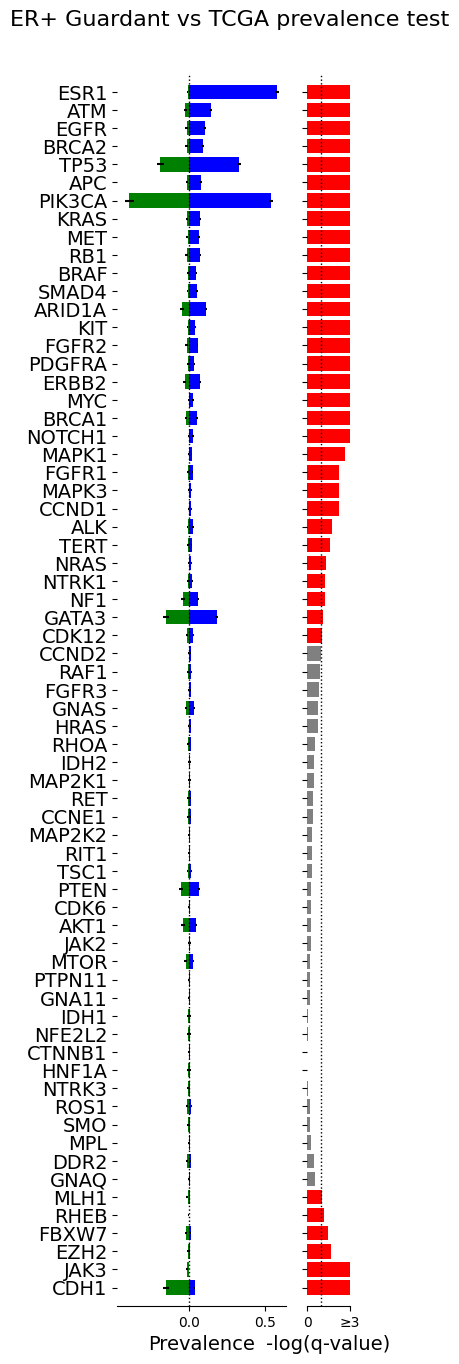

In [24]:
x = np.arange(len(order))
fig, axes = plt.subplots(figsize=(3, 16), ncols=2, nrows=1, sharey=True, gridspec_kw={'width_ratios': (4, 1)})

axes[0].barh(x, full_er_pos_prev[order], color='blue', label='Guardant', xerr=full_er_pos_prev_error[:, full_err_index])
axes[0].barh(x, -tcga_er_pos_prev[order], color='green', label='TCGA', xerr=tcga_er_pos_prev_error[:, tcga_err_index])
axes[0].axvline(0, linestyle='dotted', lw=1, c='k')
axes[0].set_ylim(min(x) - 1, max(x) + 1)
axes[0].set_xlabel('Prevalence', fontsize=14)
axes[0].set_xticklabels(np.abs(np.round(axes[0].get_xticks(), 1)))
axes[0].set_yticks(x)
axes[0].set_yticklabels(order, fontsize=14)

sig_y = [order.index(x) for x in order if q_values[x] <= .1]
no_sig_y = [order.index(x) for x in order if q_values[x] > .1]
axes[1].barh(sig_y, -np.log10(q_values[order][q_values[order] <= .1]), color='red')
axes[1].barh(no_sig_y, -np.log10(q_values[order][q_values[order] > .1]), color='gray')
axes[1].axvline(-np.log10(.1), linestyle='dotted', lw=1, c='k')
axes[1].set_xlim(0, 3)
axes[1].set_xticks([0, 3])
axes[1].set_xticklabels(['0','≥3'])
axes[1].set_xlabel('-log(q-value)', fontsize=14)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
plt.suptitle('ER+ Guardant vs TCGA prevalence test', fontsize=16, y=.92)
# plt.savefig('er+_guardant_vs_tcga_prev_test.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()